# Customized Product Proposal - Recommender System

--------------------------------------------------------

@author: jl-datascientist (Jérémy Lecourt)

Objectif:
Système avancé de recommandation de produits afin d'effectuer des propositions personnalisées selon les profils des clients.

Cadre du projet:
Application pour élaborer une proposition personnalisée de Films adaptée selon les profils des individus, en utilisant un jeux de données obtenus depuis le site Imdb.com, plus grand recueil de films/notations utilisateurs sur la toile.

--------------------------------------------------------

## ETAPE 3 : Feature engineering et First modelisation

### 0 - Import datasets (prepared data from Step 1)

In [1]:
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

data_r = pd.read_csv(r"Save\data_r.csv")

data_r['rating'] = data_r['rating'] *2
data_r.head()


,movieId,originalTitle,averageRating,numVotes,userId,rating,timestamp,date_rating
0,1,Toy Story,8.3,867989,3,8.0,944919407,1999-12-11 13:36:47
1,1,Toy Story,8.3,867989,6,10.0,858275452,1997-03-13 17:50:52
2,1,Toy Story,8.3,867989,8,8.0,833981871,1996-06-05 13:37:51
3,1,Toy Story,8.3,867989,11,9.0,1230858821,2009-01-02 01:13:41
4,1,Toy Story,8.3,867989,12,8.0,859063718,1997-03-22 20:48:38


Pour approfondir l'étude des comportements clients lors de leur notation, on analyse en détail le dataset des ratings clients.

### 1 - Feature engineering and selection

On cherche à créer les variables suivantes, qui intuitivement permettent de détecter des comportements divergents d'un client à l'autre :

-> le nombre de votes de chaque client

-> la moyenne des votes de chaque client

-> l'écart-type des votes de chaque client

-> la distance du vote à la moyenne attribuée au film (influence lors de la notation)

-> l'étendue des votes de chaque client dans le temps (durée activité en jours)


In [2]:
# Influence of movie average rating (precalculation)
data_r['distAvg_mov'] = abs(data_r['rating']-data_r['averageRating'])

# Aggregation per User-Id (customer-oriented point of view)
viz_cust = data_r.groupby('userId')

# Define for each customer new features to evaluate its rating behavior
viz_adv = pd.DataFrame(columns = ['nbVotes','avg_cust','std_cust','distAvg_mov','activity_in_day'])
viz_adv['nbVotes'] = viz_cust['movieId'].count()
viz_adv['avg_cust'] = viz_cust['rating'].mean()
viz_adv['std_cust'] = viz_cust['rating'].std()
viz_adv['distAvg_mov'] = viz_cust['distAvg_mov'].mean()
viz_adv['activity_in_day'] = (viz_cust['timestamp'].max() - viz_cust['timestamp'].min())/(3600*24)
viz_adv = viz_adv[viz_adv['activity_in_day']>0]

In [3]:
viz_adv.describe()

,nbVotes,avg_cust,std_cust,distAvg_mov,activity_in_day
count,116547.000000,116547.000000,116547.000000,116547.000000,116547.000000
mean,110.058311,7.168231,1.899283,1.545528,223.244603
std,148.431920,0.871754,0.469534,0.459416,661.957522
min,16.000000,1.718254,0.000000,0.311180,0.000012
25%,34.000000,6.639159,1.570262,1.227360,0.013241
50%,60.000000,7.208791,1.859126,1.478086,0.066748
75%,122.000000,7.754386,2.190890,1.782759,58.356944
max,3535.000000,10.000000,4.531496,5.633778,6405.271076


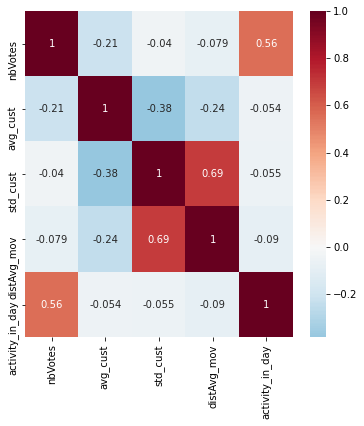

In [4]:
plt.figure(figsize=(6,6))
sns.heatmap(viz_adv.corr(),  annot=True, cmap="RdBu_r", center =0);

Les principales corrélations parmi les 5 nouvelles variables créées pour évaluer les différents comportements lors des votes client sont assez intuitives :

    -> L'écart-type des votes d'un client est fortement lié à sa dispersion par rapport à la notation moyenne des films (plus un client a tendance a se disperser dans sa notation, moins il est influencé par la note moyenne du film)
    
    -> Le nombre de votes client est fortement lié à la durée d'activité du client (plus un client a de l'ancienneté sur le site, plus il enregistre de votes sur les films)
    
On choisit de garder les 3 premières variables créées pour la visualisation avancée, les 2 dernières étant fortement corrélées, ce qui nous permettra de représenter ces comportements clients dans un nuage de point 3D en dernière partie.

### 2 - Clustering (unsupervised learning)

Au préalable, on effectue un clustering client sur base de ces variables de comportement de notation client, la répartition la plus clivante est trouvée pour 4 groupes de clients.

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation des données
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(viz_adv)

# Algorithme de K-means
from sklearn.cluster import KMeans

cluster = 4
kmeans = KMeans(n_clusters = cluster)
kmeans.fit(X_norm)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

for i in range (0,cluster):
    print('cluster ',i,':', labels[labels==i].size,'UserId')

cluster  0 : 46410 UserId
cluster  1 : 33168 UserId
cluster  2 : 31278 UserId
cluster  3 : 5691 UserId


### 3 - Advanced visualisation (customer behavior)

On ajoute l'information de cluster dans le dataframe, ce qui permet de visualiser les 4 clusters clients trouvés en fonctions des 3 variables principales sélectionnées, le tout représenté dans un nuage de point 3D.

In [6]:
viz_prep = viz_adv.copy().reset_index()
viz_prep['cluster']=pd.DataFrame(data=labels)
#viz_prep = viz_prep[1000:2000]

viz_adv0 = viz_prep[viz_prep['cluster']==0]
viz_adv1 = viz_prep[viz_prep['cluster']==1]
viz_adv2 = viz_prep[viz_prep['cluster']==2]
viz_adv3 = viz_prep[viz_prep['cluster']==3]

print(viz_adv0.shape[0],viz_adv1.shape[0],viz_adv2.shape[0],viz_adv3.shape[0])

46410 33168 31278 5691


<IPython.core.display.Javascript object>


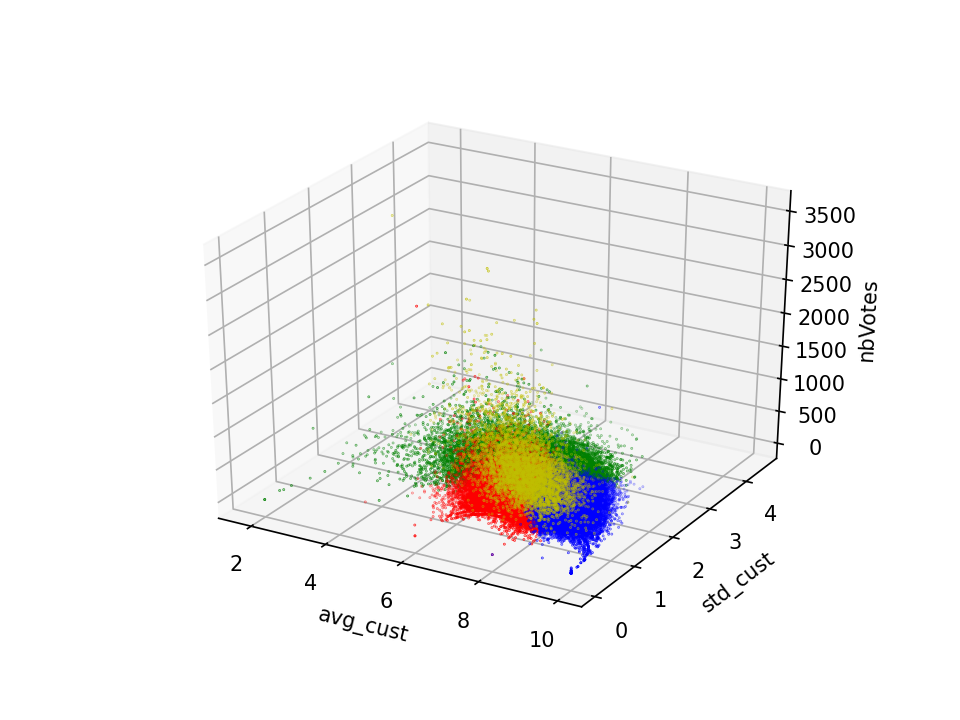

In [7]:
# Visualise customer rating behavior with 3D scatter figure (with clustering results)
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x0 = viz_adv0.avg_cust
y0 = viz_adv0.std_cust
z0 = viz_adv0.nbVotes

ax.scatter(x0, y0, z0, s=0.1,c='r')

x1 = viz_adv1.avg_cust
y1 = viz_adv1.std_cust
z1 = viz_adv1.nbVotes

ax.scatter(x1, y1, z1, s=0.1,c='b')

x2 = viz_adv2.avg_cust
y2 = viz_adv2.std_cust
z2 = viz_adv2.nbVotes

ax.scatter(x2, y2, z2, s=0.1,c='g')

x3 = viz_adv3.avg_cust
y3 = viz_adv3.std_cust
z3 = viz_adv3.nbVotes

ax.scatter(x3, y3, z3, s=0.1,c='y')

ax.set_xlabel('avg_cust')
ax.set_ylabel('std_cust')
ax.set_zlabel('nbVotes')

plt.show()

En conclusion de cette visualisation avancée pour traduire la notation client, on distingue 3 principaux types de comportements clients (et un dernier par extension qui est un peu plus restreint que les 3 autres en nombre de clients représentés) :

-> En Vert : Des clients avec une moyenne de notation très éparpillée (entre 4 et 8), et caractérisés par une dipersion des notes la plus elevée (écart-type important).

-> En Bleu : Des clients caractérisés par une moyenne de notation plus elevée que la normale (>8).

-> En Rouge : Des client plus commums caractérisés avec une moyenne de notation classique concentrée autour de la notation moyenne (entre 6 et 8), et une dispersion des notes normale aussi (pas trop de dispersion autour de la moyenne).

-> En Jaune : Une extension des clients précédents avec une moyenne et une dispersion assez commune, mais moins nombreux car caractérisés par un nombre de votes plus important que le reste des autres clients.
